In [11]:
scale_columns = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
    "y_installment",
    "y_installment_timestep",
    "y_state_cum_overduelength",
    "y_remaining_debt",
    "y_state_capital",
    "y_state_interests",
    "y_state_penalty",
]

In [12]:
features = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
]


targets = [
    # "y_installment",
    # "y_installment_timestep",
    # "y_state_cum_overduelength",
    # "y_remaining_debt",
    # "y_state_capital",
    # "y_state_interests",
    # "y_state_penalty",
    # "installment_done",
    # "loan_done",
    "recovery_rate_weighted",
]

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler


class LoanSimDataset(Dataset):
    def __init__(
        self,
        csv_file_path,
        scale_columns,
        feature_columns,
        target_columns,
        group="train",
    ):
        # -------------------------------------------------------
        # read the csv file
        data = pd.read_csv(csv_file_path)
        # choose train or test data for RLsimulator
        # rlsim_data = data.loc[(data["group"] == group)]
        rlsim_train_data = data.loc[data["group"] == "train"]
        rlsim_test_data = data.loc[
            data["group"] == "test"]
        # -------------------------------------------------------
        # scale the data
        scaler = StandardScaler()
        # we use train data to fit the scaler
        train_scaled = scaler.fit_transform(
            rlsim_train_data[scale_columns]
        )
        if group == "train":
            # rlsim_data = rlsim_train_data
            train_scaled_df = pd.DataFrame(train_scaled, columns=scale_columns)
            train_scaled_df_full = pd.concat(
                [
                    train_scaled_df.reset_index(drop=True),
                    rlsim_train_data[
                        ["installment_done", "loan_done", "recovery_rate_weighted", "loan_id"]
                    ].reset_index(drop=True),
                ],
                axis=1,
            )
            rlsim_data = train_scaled_df_full
        else:
            test_scaled = scaler.transform(rlsim_test_data[scale_columns])
            test_scaled_df = pd.DataFrame(test_scaled, columns=scale_columns)
            test_scaled_df_full = pd.concat(
                [
                    test_scaled_df.reset_index(drop=True),
                    rlsim_test_data[
                        ["installment_done", "loan_done", "recovery_rate_weighted", "loan_id"]
                    ].reset_index(drop=True),
                ],
                axis=1,
            )
            rlsim_data = test_scaled_df_full
        # print(rlsim_data.head(14))
        # -------------------------------------------------------
        # group the data by loan_id
        self.grouped_data = rlsim_data.groupby("loan_id")
        # -------------------------------------------------------
        self.features_columns = feature_columns
        self.target_columns = target_columns
        self.sequences = self.create_sequences()

    def create_sequences(self):
        sequences = []
        for loan_id, group in self.grouped_data:
            # print(loan_id)
            features = group[self.features_columns].values
            targets = group[self.target_columns].values
            sequences.append((features, targets))
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(
            target, dtype=torch.float32
        )

In [14]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    features, targets = zip(*batch)  # unzip the batch and get the features and targets
    # using pad_sequence to pad sequences to the same length
    padded_features = pad_sequence(features, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)
    # get the actual lengths of the sequences
    lengths = torch.tensor([len(f) for f in features])
    return padded_features, padded_targets, lengths

In [15]:
dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns = scale_columns,
    feature_columns = features,
    target_columns = targets,
    group="train",
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [16]:
# use the test data as validation data
val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=targets,
    group="test",  # read the test data
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [17]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [18]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.ReLU(),
        )

    def forward(self, x, lengths):  # Accepts raw input and lengths
        # Pack sequence
        packed_x = pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed_x)
        lstm_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # Pass through MLP
        out = self.mlp(lstm_out)
        return out

In [24]:
from torch import optim


# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100


model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)


criterion = nn.MSELoss()  # regression question, so use MSE as the Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
import numpy as np

model.to(device)

# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter


train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, lengths in dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss)
    avg_train_loss = running_loss / len(dataloader)

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, lengths in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_losses.append(val_loss)
    avg_val_loss = val_loss / len(val_dataloader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}"
    )

    # Logic of Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # rest the counter
        torch.save(model.state_dict(), "best_model.pth")  # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break  # stop training the model if early stopping is triggered

Epoch 1/100, Train Loss: 0.00258417, Val Loss: 0.00214669
Epoch 2/100, Train Loss: 0.00201624, Val Loss: 0.00195801
Epoch 3/100, Train Loss: 0.00191837, Val Loss: 0.00186240
Epoch 4/100, Train Loss: 0.00186050, Val Loss: 0.00186220
Epoch 5/100, Train Loss: 0.00180010, Val Loss: 0.00183894
Epoch 6/100, Train Loss: 0.00179716, Val Loss: 0.00182435
Epoch 7/100, Train Loss: 0.00175970, Val Loss: 0.00187156
Epoch 8/100, Train Loss: 0.00173810, Val Loss: 0.00180092
Epoch 9/100, Train Loss: 0.00174232, Val Loss: 0.00183539
Epoch 10/100, Train Loss: 0.00173608, Val Loss: 0.00181244
Epoch 11/100, Train Loss: 0.00173246, Val Loss: 0.00182607
Epoch 12/100, Train Loss: 0.00170519, Val Loss: 0.00180364
Epoch 13/100, Train Loss: 0.00169878, Val Loss: 0.00183128
Epoch 14/100, Train Loss: 0.00170703, Val Loss: 0.00181493
Epoch 15/100, Train Loss: 0.00170606, Val Loss: 0.00181226
Epoch 16/100, Train Loss: 0.00167485, Val Loss: 0.00179884
Epoch 17/100, Train Loss: 0.00170744, Val Loss: 0.00175764
Epoch 

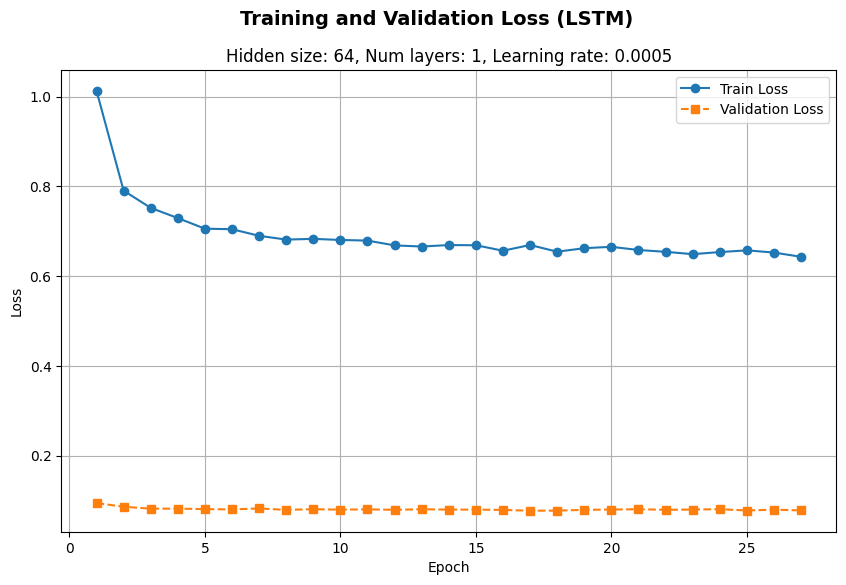

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM)", weight="bold", size=14)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
plt.savefig("training_validation_loss_lstm.png")
plt.show()